<sub><sup>Copyright (C) 2025 J. Heinzmann, A. Benady, ETH Zürich</sub></sup>

<sub><sup>
This file is part of the `nlfea` package for the course Computational Mechanics II: Nonlinear FEA at ETH Zurich.
This software is exclusively intended for personal, educational purposes only in the context of the above course.
It must not be used outside of this scope without the explicit consent of the author(s).
</sub></sup>

# Project 4

The third project revolves around the FE implementation of $J_2$-plasticity.

This notebook will guide you through all the necessary steps.

## 1. Implementation and Validation with Pressurized Pipe

We start with an example setup where an analytical solution is available, such that we can properly validate our implementation.
Namely, we consider a pipe under internal pressure which will start to plastify once the internal pressure reaches a certain threshold.
We exploit the symmetry of the test (and its solution fields) to compute only a segment of the pipe.

The setup is taken from:

[E.A. de Souza Neto (2008): Computational Methods for Plasticity](doi.org/10.1002/9780470694626), pp. 245ff, [based on Hill, 1950]

In [1]:
# external dependencies
import numpy as np

# internal dependencies
from nlfea import Model, Solver, mesh, materials, elements, solution, post

# initialize empty model object
model_pipesegment = Model()

# mesh
r_inner = 100  # mm
r_outer = 200  # mm
(model_pipesegment.nodes, model_pipesegment.connectivity) = mesh.plane.arc(
    r_inner=r_inner,
    r_outer=r_outer,
    φ_start=0,
    φ_end=90,
    num_nodes_r=7,
    num_nodes_φ=15,
    element_type="quad8",
)

# define type of element
model_pipesegment.parent_element = elements.Quad(
    kinematics="linear", element_type="quad8", integration="reduced"
)

# material
model_pipesegment.material = materials.Hooke_J2plasticity(E=210, ν=0.3, σ_0=0.24, K=0)

# find node sets for the application of BCs
inner_edge = np.where(np.isclose(np.linalg.norm(model_pipesegment.nodes, axis=1), 100))[
    0
].tolist()
φ_start = mesh.nodesets.find(model_pipesegment.nodes, Y=0)
φ_end = mesh.nodesets.find(model_pipesegment.nodes, X=0)

# Dirichlet BCs
model_pipesegment.dirichlet_bcs = (("fix_X", φ_end), ("fix_Y", φ_start))

# Neumann BCs
t_bar = -0.18
model_pipesegment.neumann_bcs = (("t_N", inner_edge, t_bar),)

# solver parameters
solver_pipesegment = Solver()
solver_pipesegment.num_increments = 20
solver_pipesegment.tolerance_nr = 1e-7
solver_pipesegment.max_iter = 20
solver_pipesegment.control_method = "load"

# get DOF used for the monitoring in the plots
monitoring_node = int(
    np.where(
        np.isclose(model_pipesegment.nodes[:, 0], r_outer)
        & np.isclose(model_pipesegment.nodes[:, 1], 0.0)
    )[0]
)
monitoring_node_dof = np.array([[monitoring_node, 0]])
solver_pipesegment.monitoring_dof = int(
    monitoring_node_dof[0, 0] * 2 + monitoring_node_dof[0, 1]
)


# set analytical solution
def analytical_solution(u):
    return post.analytical_solutions.pressurized_cylinder(
        model_pipesegment.material[0], r_outer, r_inner, t_bar, u
    )


# set output directory
solver_pipesegment.result_dir = "project4_pressurizedcyclinder"

C:\Users\Castravete\AppData\Local\Temp\ipykernel_23840\1576875938.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  monitoring_node = int(


**TASK 1**: Add the missing return mapping algorithm in `nlfea/materials/hooke_J2plasticity.py`.

Now, we can start the incremental-iterative solution process and plot the residuals of the Newton-Raphson solver.

model dimension:		2
chosen element:			quad8
number of nodes:		84
number of elements:		21
number of DOFs:			168

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=1.959778310481615e-14
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=2.4364879146798108e-14
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=3.0361701257930896e-14
___________________________________________________________________________ 
increment: 3
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=4.837462238125877e-14
___________________________________________________________________________ 
increment: 4
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=5.109361910274448e-14
______

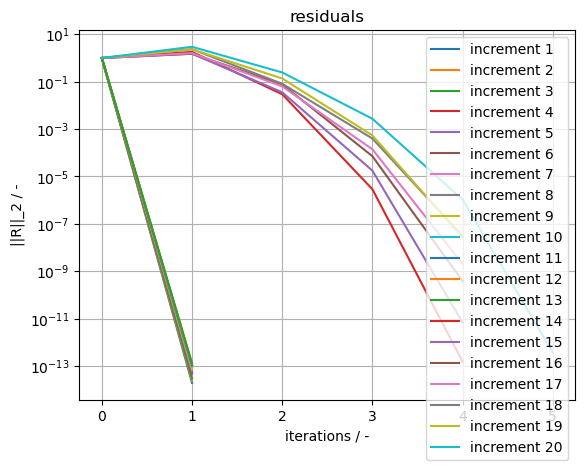

In [2]:
# preprocess model and start computations
model_pipesegment.prepare()
solution.incremental.solve(model_pipesegment, solver_pipesegment)

# plot residuals
post.plots.residuals(solver_pipesegment.monitoring)

**TASK 2**: What can you observe in terms of the convergence behavior of the elastic load steps vs. once plastic flow occurs? Answer in the empty Markdown box below.

The Newton-Raphson algorithm converges in one step for the linear-elastic problem (like in the linear FEA lecture), but as we enter the plastic regime, the problem becomes nonlinear (material non-linearity in this case). The algorithm then needs a few iterations to minimize the residual before moving on to the next increment. (It's hard to say what exactly it's "trying out" as it changes the displacements in the intermediate steps before it converges, but that's just the magic of the Newton-Raphson.) 

Let's also visualize the deformation of the pipe.

In [3]:
post.interactive.continuum(
    solver_pipesegment.result_dir, field="u", deformation_magnification=200.0
)

Widget(value='<iframe src="http://localhost:52926/index.html?ui=P_0x24c02d99940_0&reconnect=auto" class="pyvis…

Finally, to validate your implementation, make sure that your numerically obtained solution matches the analytical solution below.

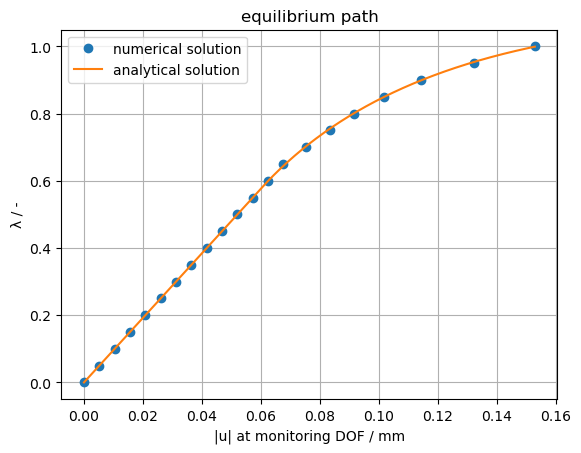

In [4]:
# plot results
# here, we work with the internal pressure vs. the radial displacement at the outer edge
# hence, we exploit the function equilibrium_path to plot the load factor vs.
# the displacement at the monitoring DOF (the analytical solution is also normalized with t_bar)
post.plots.equilibrium_path(solver_pipesegment.monitoring, analytical_solution)

**TASK 3**: Checking our material parameter definition above, we see that essentially a perfect plasticity model was used (by setting the hardening modulus to zero, $K=0$). Still, we can see some hardening-like behavior in the system response. How can this be explained? Answer in the empty Markdown box below.

I believe this hardening behavior we see at the structure level is due to "stress redistribution". Basically, as some parts of the structure begin to plastically deform (but stay at the same stress level), they allow  other parts of the structure to increase in strain (at least until the yield stress). As the stress is still increasing in different parts of the structure, we still see hardening, until everything has plasticized.

(This can be seen if you change the field to alpha in the visualization above, it )

## 2. Dogbone specimen

Next, we want to replicate a more realistic test setup and use a hardening model, namely a Dogbone specimen. With this, you can test if also your implementation of hardening is correct.

model dimension:		2
chosen element:			quad8
number of nodes:		1413
number of elements:		430
number of DOFs:			2826

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=5.412072882767601e-13
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=6.898616830938348e-13
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=9.343084006180604e-13
___________________________________________________________________________ 
increment: 3
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=1.359810806325105
		iteration: 2, residual_norm=0.6947330604728728
		iteration: 3, residual_norm=0.02980615387945946
		iteration: 4, residual_norm=0.0008464753467775722
		iteration: 5, residual_norm=9.7

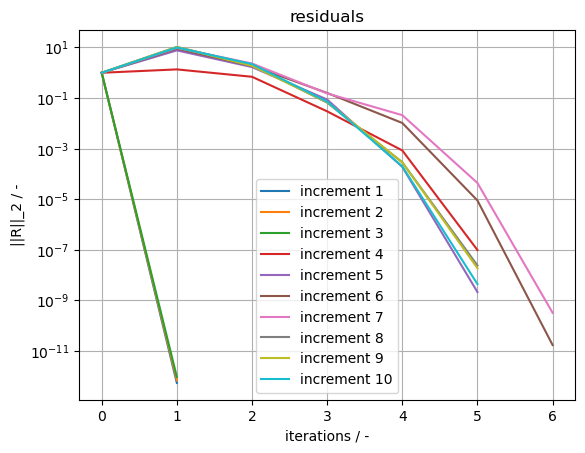

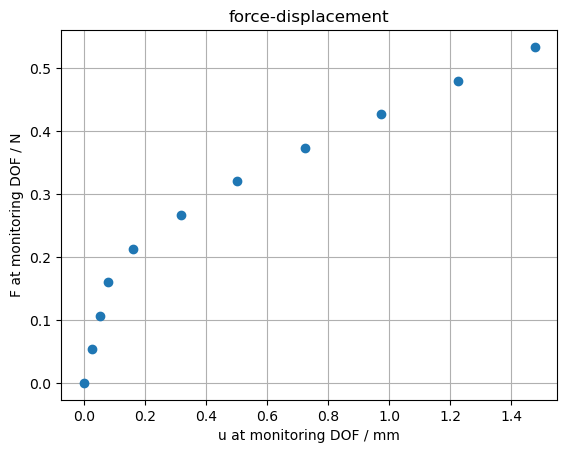

In [5]:
# initialize empty model object
model_dogbone = Model()

# mesh
(model_dogbone.nodes, model_dogbone.connectivity) = mesh.external.load(
    "nlfea/mesh/dogbone.inp"
)

# define type of element
model_dogbone.parent_element = elements.Quad(
    kinematics="linear", element_type="quad8", integration="reduced"
)

# material
model_dogbone.material = materials.Hooke_J2plasticity(E=210, ν=0.3, σ_0=0.24, K=20)

# find node sets for the application of BCs
lower_edge = mesh.nodesets.find(model_dogbone.nodes, Y=0)
upper_edge = mesh.nodesets.find(model_dogbone.nodes, Y=100)

# Dirichlet BCs
model_dogbone.dirichlet_bcs = (("fix_X", [lower_edge[0]]), ("fix_Y", lower_edge))

# Neumann BCs
model_dogbone.neumann_bcs = (("t_Y", upper_edge, 0.4),)

# solver parameters
solver_dogbone = Solver()
solver_dogbone.num_increments = 10
solver_dogbone.tolerance_nr = 1e-7
solver_dogbone.max_iter = 20
solver_dogbone.control_method = "load"

# get DOF used for the monitoring in the plots
monitoring_node = upper_edge[-1]
monitoring_node_dof = np.array([[monitoring_node, 1]])
solver_dogbone.monitoring_dof = int(
    monitoring_node_dof[0, 0] * 2 + monitoring_node_dof[0, 1]
)

# set output directory
solver_dogbone.result_dir = "project4_dogbone"

# preprocess model and start computations
model_dogbone.prepare()
solution.incremental.solve(model_dogbone, solver_dogbone)

# plot residuals
post.plots.residuals(solver_dogbone.monitoring)

# plot results
post.plots.force_displacement(solver_dogbone.monitoring)

If your implementation of the hardening model is correct, you should also see hardening in the above force-displacement response of the system.

Now, we want to visualize not only the deformation, but also the evolution of the plastic variables. To do so, below we select `field="α"` or `field="ε_pl"`. Recall that these values have been computed at the Gauss points, and for PyVista/ ParaView, they have been projected to the nodes (so we don't see the actual values at the Gauss points, but a smoothed-out, approximate picture). For the strain tensor, our code can currently unfortunately only display a norm of the tensor (instead of the individual components).

In [6]:
# plot deformed mesh
post.interactive.continuum(
    solver_dogbone.result_dir, field="u", deformation_magnification=20.0
)
post.interactive.continuum(
    solver_dogbone.result_dir, field="α", deformation_magnification=20.0
)
post.interactive.continuum(
    solver_dogbone.result_dir, field="ε_pl", deformation_magnification=20.0
)

Widget(value='<iframe src="http://localhost:52926/index.html?ui=P_0x24c07bc3110_1&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:52926/index.html?ui=P_0x24c07c4c410_2&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:52926/index.html?ui=P_0x24c07c4d590_3&reconnect=auto" class="pyvis…

## 3. Bonus: Plate with Holes

Finally with this last project, we can also compute the test which has been at the cover of the slides/ the Moodle course!
The setup for a plate with holes and an applied traction on the upper edge is given below; be aware that since the code is written in Python, this might take quite a while to compute...
For this reason, FEM codes are typically written in low-level, compiled language (such as `C` or `C++`), while also relying on parallel computing.
Also, `PyVista` is reaching its limits in terms of visualization.
If you're curious, you can open the raw output files in the folder `project4_platewithholes` instead with [ParaView](https://www.paraview.org/download/), where you can also take a look at individual tensor components etc.

model dimension:		2
chosen element:			quad8
number of nodes:		6287
number of elements:		1967
number of DOFs:			12574

___________________________________________________________________________ 
increment: 0
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=6.458282792763727e-13
___________________________________________________________________________ 
increment: 1
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=7.600967156108049e-13
___________________________________________________________________________ 
increment: 2
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=8.676197847189868e-13
___________________________________________________________________________ 
increment: 3
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=1.014012588124442e-12
___________________________________________________________________________ 
increment: 4
		iteration: 0, residual_norm=1.0
		iteration: 1, residual_norm=1.1836516426183297e-12
_

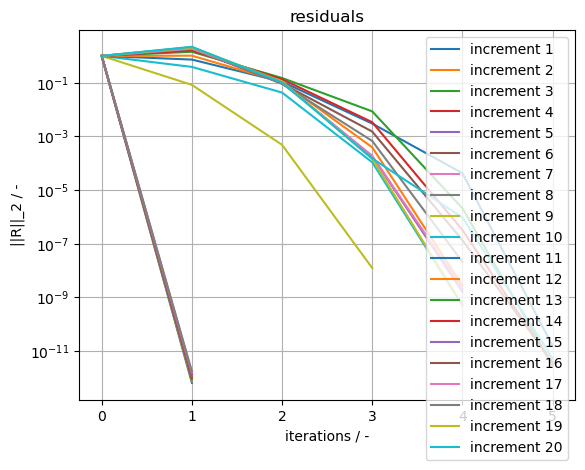

Widget(value='<iframe src="http://localhost:52926/index.html?ui=P_0x24c03e00410_4&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:52926/index.html?ui=P_0x24c03e02e90_5&reconnect=auto" class="pyvis…

In [7]:
# initialize empty model object
model_pwh = Model()

# mesh
(model_pwh.nodes, model_pwh.connectivity) = mesh.external.load(
    "nlfea/mesh/plate_with_holes.inp"
)

# define type of element
model_pwh.parent_element = elements.Quad(
    kinematics="linear", element_type="quad8", integration="reduced"
)

# material
model_pwh.material = materials.Hooke_J2plasticity(E=210, ν=0.3, σ_0=25, K=75)

# find node sets for the application of BCs
lower_edge = mesh.nodesets.find(model_pwh.nodes, Y=0)
lower_left_corner = mesh.nodesets.find(model_pwh.nodes, X=0, Y=0)
upper_edge = mesh.nodesets.find(model_pwh.nodes, Y=1)

# Dirichlet BCs
model_pwh.dirichlet_bcs = (("fix_X", [lower_edge[0]]), ("fix_Y", lower_edge))

# Neumann BCs
model_pwh.neumann_bcs = (("t_Y", upper_edge, 7.5),)

# solver parameters
solver_pwh = Solver()
solver_pwh.num_increments = 20
solver_pwh.tolerance_nr = 1e-7
solver_pwh.max_iter = 20
solver_pwh.control_method = "load"

# get DOF used for the monitoring in the plots
monitoring_node = 137
monitoring_node_dof = np.array([[monitoring_node, 1]])
solver_pwh.monitoring_dof = int(
    monitoring_node_dof[0, 0] * 2 + monitoring_node_dof[0, 1]
)

# set output directory
solver_pwh.result_dir = "project4_platewithholes"

# preprocess model and start computations
model_pwh.prepare()
solution.incremental.solve(model_pwh, solver_pwh)

# plot residuals
post.plots.residuals(solver_pwh.monitoring)

# plot deformed mesh
post.interactive.continuum(solver_pwh.result_dir)
post.interactive.continuum(
    solver_pwh.result_dir, field="α", deformation_magnification=1.0
)

For the submission of this project, upload on Moodle:

- this Jupyter notebook, and
- the file `materials/hooke_J2plasticity.py`.

Congrats, you finished the last coding project of the course!